In [1]:
import praw
import pandas as pd
import re
from transformers import pipeline
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import string

done


In [2]:
# Reddit API logins
client_id = "5VNLWe7urSYH7YmfDLhTPw"
client_secret = "SPAzlLXT-plWxi1T4L3CQTlTcbdVoQ"
user_agent = "Chemical-Staff-4194"

# connecting to the reddit API
reddit = praw.Reddit(client_id=client_id,
                     client_secret=client_secret,
                     user_agent=user_agent)

# Function for gathering comments from x threads of chosen subreddit y
def gather_comments(sub, threadnumber = 50):
    subreddit = reddit.subreddit(sub)
    data = []
    for submission in subreddit.hot(limit = threadnumber):
        submission.comments.replace_more(limit = 0)
        for comment in submission.comments.list():
            data.append([submission.title, comment.body])
            
    df = pd.DataFrame(data, columns=["Thread Title", "Comment"])
    return df

In [3]:
df_austria = gather_comments("Austria", 200)
df_austria.to_csv("austria.csv", mode = "a", index = False, header = False)
print(df_austria.head())

                                        Thread Title  \
0  Krieg in der Ukraine - weiterhin nicht nachlas...   
1  Krieg in der Ukraine - weiterhin nicht nachlas...   
2  Krieg in der Ukraine - weiterhin nicht nachlas...   
3  Krieg in der Ukraine - weiterhin nicht nachlas...   
4  Krieg in der Ukraine - weiterhin nicht nachlas...   

                                             Comment  
0                                          [removed]  
1  Was für ein Unsinn. Wer wirklich Frieden will,...  
2  Bravo. Ich kann mir gerade nicht vorstellen, w...  
3  Ne, wir sollten voll lieb zum Putin sein, weil...  
4                     ich bin klar gegen die Ukraine  


In [4]:
df_germany = gather_comments("de", 200)
df_germany.to_csv("germany.csv", mode = "a", index = False, header = False)
print(df_germany.head())

         Thread Title                                            Comment
0  Montag-Laberfaden   Klapp' die Antworten auf diesen Kommentar auf,...
1  Montag-Laberfaden   An alle die heute Feiertag haben: Fies, aber g...
2  Montag-Laberfaden                                 Urlaub vorbei. Bäh.
3  Montag-Laberfaden   Das einzig gute am Start des neuen Arbeitsjahr...
4  Montag-Laberfaden   Feiertag heute, Gott sei Dank. Noch ein Tag me...


In [5]:
df_switzerland = gather_comments("Switzerland", 200)
df_switzerland.to_csv("switzerland.csv", mode = "a", index = False, header = True)
print(df_switzerland.head())

              Thread Title                                            Comment
0  Cost of naturalization   Sounds right. The cost is not high. The proces...
1  Cost of naturalization   > How much might that be, roughly? I'm from Ge...
2  Cost of naturalization   Pretty close I think. Especially as you don’t ...
3  Cost of naturalization                   You ever seen the cost for Basel?
4  Cost of naturalization   It depends on where you live and where you com...


In [6]:
# dropping duplicate comments
df_austria = pd.read_csv("austria.csv")
df_germany = pd.read_csv("germany.csv")
df_switzerland = pd.read_csv("switzerland.csv")
df_austria = df_austria.drop_duplicates()
df_germany = df_germany.drop_duplicates()
df_switzerland = df_switzerland.drop_duplicates()

In [7]:
# removing different symbols that might interfer with the analysis and wordcloud generation
def cleanTxt(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)  # Remove @mentions
    text = re.sub(r'#', '', text)  # Remove the '#' symbol
    text = re.sub(r'RT[\s]+', '', text)  # Remove 'RT'
    text = re.sub(r'https?:\/\/\S+', '', text)  # Remove hyperlinks
    text = re.sub(r':', '', text)  # Remove colons
    return text

df_austria["Comment"] = df_austria["Comment"].apply(cleanTxt)
df_germany["Comment"] = df_germany["Comment"].apply(cleanTxt)
df_switzerland["Comment"] = df_switzerland["Comment"].apply(cleanTxt)

In [8]:
# removing emojis and similiars that might interfer with the analysis and wordcloud generation
def remove_emoji(string):
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # Chinese characters
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001F926-\U0001F937"
        u"\U00010000-\U0010FFFF"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200D"
        u"\u23CF"
        u"\u23E9"
        u"\u231A"
        u"\uFE0F"  # dingbats
        u"\u3030"
        "]+",
        flags=re.UNICODE
    )
    return emoji_pattern.sub(r'', string)

df_austria["Comment"] = df_austria["Comment"].apply(remove_emoji)
df_switzerland["Comment"] = df_switzerland["Comment"].apply(remove_emoji)
df_germany["Comment"] = df_germany["Comment"].apply(remove_emoji)

In [9]:
# starting a VADER analysis (my notebook is to slow for BERT)
vader_analyzer = SentimentIntensityAnalyzer()

# function that analyzes and evaluetes the score
def analyze_sentiment_vader(comment):
    sentiment_score = vader_analyzer.polarity_scores(comment)
    compound_score = sentiment_score["compound"]  
    
    if compound_score >= 0.05:
        return "POSITIVE"
    elif compound_score <= -0.05:
        return "NEGATIVE"
    else:
        return "NEUTRAL"

# applying the VADER analysis to the dataframe comment
df_austria["SentimentVADER"] = df_austria["Comment"].apply(analyze_sentiment_vader)
df_germany["SentimentVADER"] = df_germany["Comment"].apply(analyze_sentiment_vader)
df_switzerland["SentimentVADER"] = df_switzerland["Comment"].apply(analyze_sentiment_vader)

In [ ]:
# starting a BERT analysis (NOT TESTED MY LAPTOP CANT RUN IT :((( )
bert_analyzer = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

# function that analyzes and evaluetes the score
def analyze_sentiment_bert(comment):
    result = bert_analyzer(comment[:512])
    label = result[0]["label"]
    if "5" in label or "4" in label:
        return "POSITIVE"
    elif "1" in label or "2" in label:
        return "NEGATIVE"
    else:
        return "NEUTRAL"

df_austria["SentimentBERT"] = df_austria["Comment"].apply(analyze_sentiment_bert)
df_germany["SentimentBERT"] = df_germany["Comment"].apply(analyze_sentiment_bert)
df_switzerland["SentimentBERT"] = df_switzerland["Comment"].apply(analyze_sentiment_bert)

In [10]:
# function for drawing a chart to show how the distribution of different comments is
def draw_sentiment_chart(df, sentimenttype, title):
    plt.figure(figsize=(8, 6))
    sns.countplot(x = sentimenttype, data = df, palette = "Set2")
    plt.title(title, fontsize=16)
    plt.xlabel("Sentiment", fontsize=14)
    plt.ylabel("Amount", fontsize=14)
    plt.show()

C:\Users\david\AppData\Local\Temp\ipykernel_7268\2102984941.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = sentimenttype, data = df, palette = "Set2")


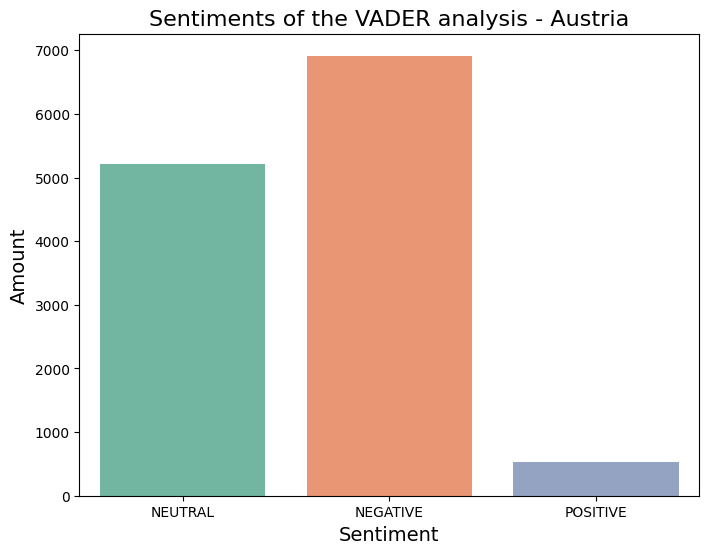

In [11]:
draw_sentiment_chart(df_austria, "SentimentVADER", "Sentiments of the VADER analysis - Austria")

C:\Users\david\AppData\Local\Temp\ipykernel_7268\2102984941.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = sentimenttype, data = df, palette = "Set2")


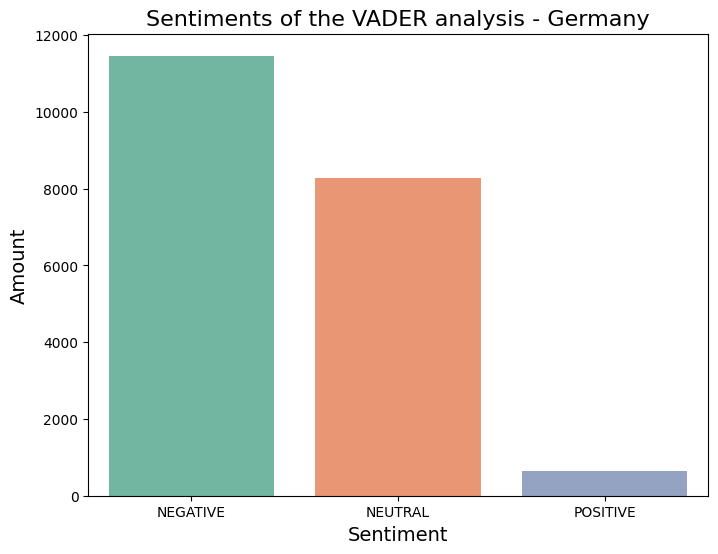

In [12]:
draw_sentiment_chart(df_germany, "SentimentVADER", "Sentiments of the VADER analysis - Germany")

C:\Users\david\AppData\Local\Temp\ipykernel_7268\2102984941.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = sentimenttype, data = df, palette = "Set2")


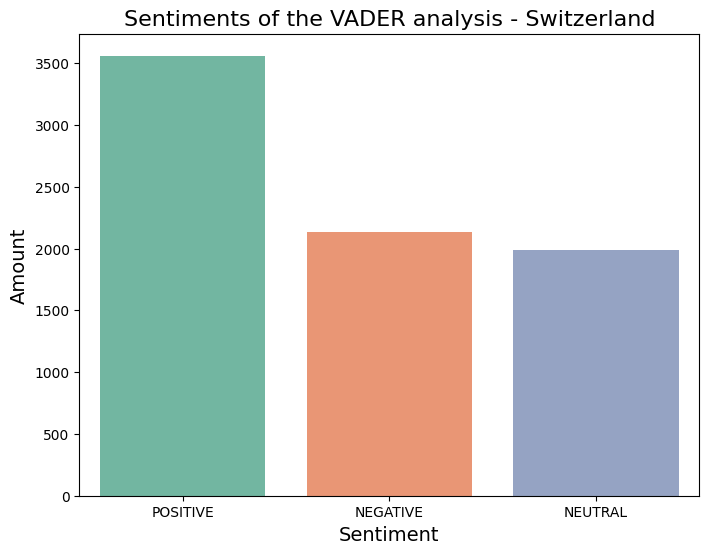

In [13]:
draw_sentiment_chart(df_switzerland, "SentimentVADER", "Sentiments of the VADER analysis - Switzerland")

In [14]:
# Download NLTK stopwords
nltk.download('stopwords')

# Load German and English stopwords due to anglicism and english threads
german_stopwords = set(stopwords.words('german'))
english_stopwords = set(stopwords.words('english'))

# Additional stopwords because NLTKs list is lacking
def load_additional_stopwords(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        additional_stopwords = set(line.strip() for line in file if line.strip())
    return additional_stopwords

# Define the file path for the additional stopwords
file_path = "stopwords_german.txt"
additional_german_stopwords = load_additional_stopwords(file_path)

# Combining the stopwords
combined_stopwords = german_stopwords.union(english_stopwords, additional_german_stopwords)

# Function to remove stopwords from text
def remove_stopwords(text):
    text = text.translate(str.maketrans('', '', string.punctuation))
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in combined_stopwords]
    return " ".join(filtered_words)

# Generate the wordcloud
def generate_wordcloud(df, sentimenttype, sentiment):
    text = " ".join(df[df[sentimenttype] == sentiment]["Comment"])
    filtered_text = remove_stopwords(text)
    wordcloud = WordCloud(width = 800, height = 400, background_color = "black").generate(filtered_text)
    
    plt.figure(figsize = (8, 6))
    plt.imshow(wordcloud, interpolation = "bilinear")
    plt.axis("off")
    plt.title(f'Wordcloud for {sentiment} Sentiment', fontsize=16)
    plt.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


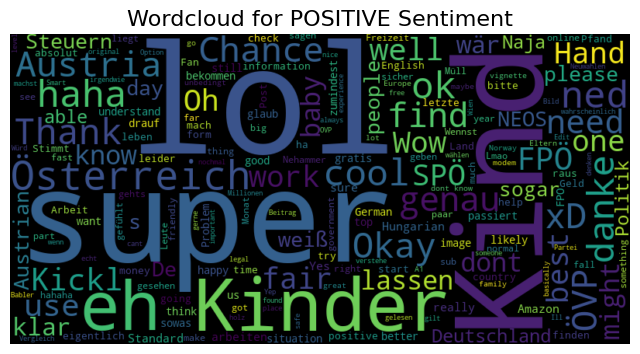

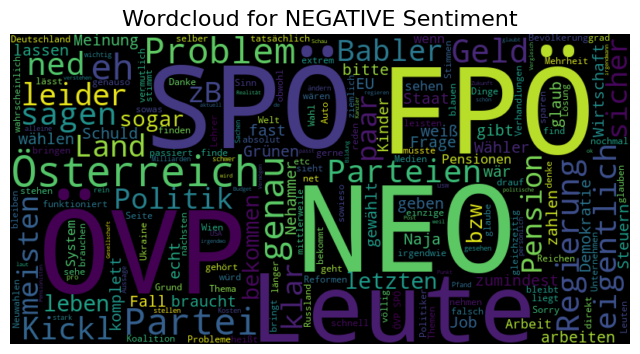

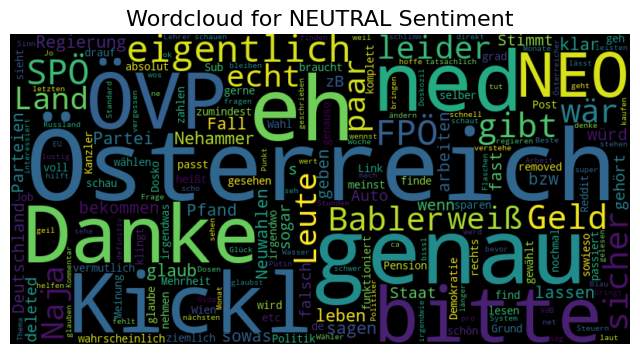

In [15]:
# Generate a wordcloud for each sentiment type
for sentiment in ['POSITIVE', 'NEGATIVE', 'NEUTRAL']:
    generate_wordcloud(df_austria, "SentimentVADER", sentiment)

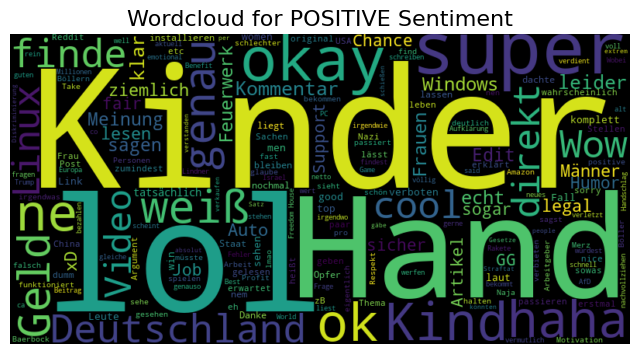

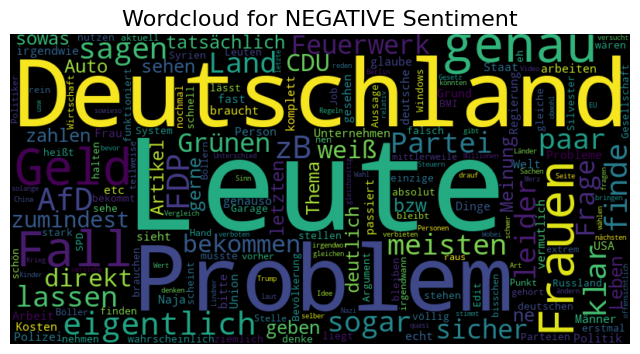

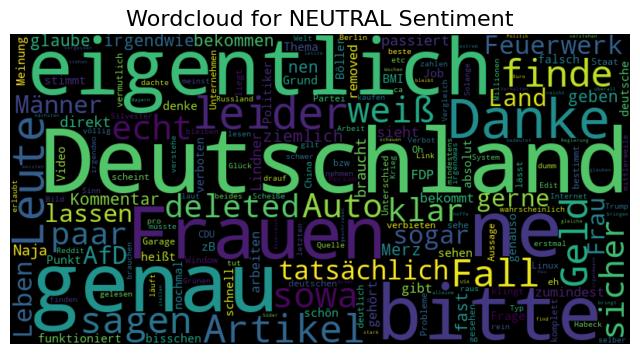

In [16]:
# Generate a wordcloud for each sentiment type
for sentiment in ['POSITIVE', 'NEGATIVE', 'NEUTRAL']:
    generate_wordcloud(df_germany, "SentimentVADER", sentiment)

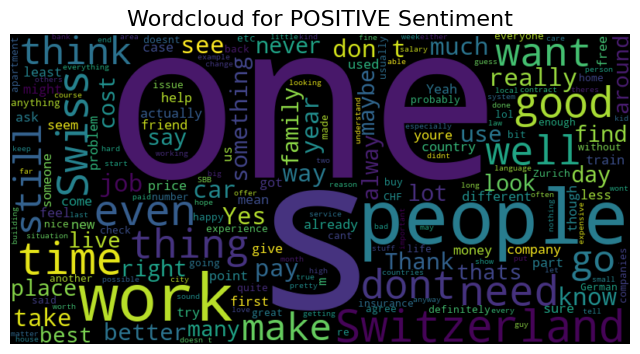

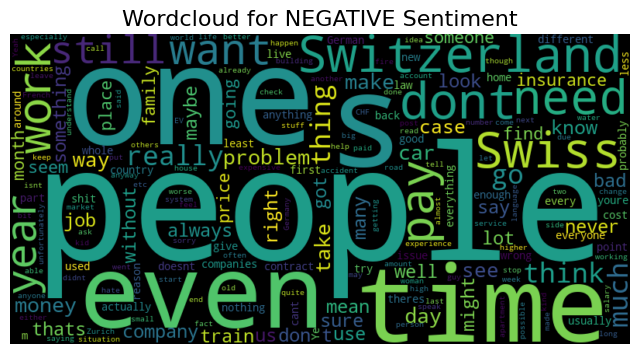

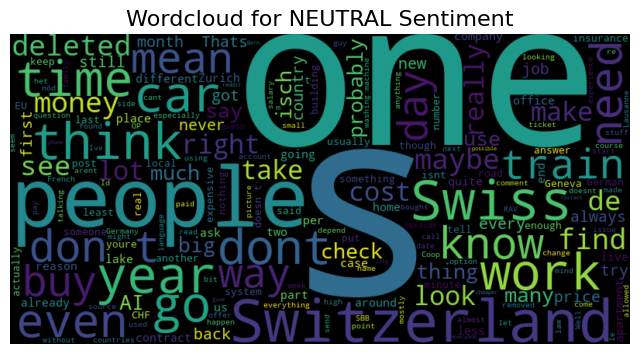

In [17]:
# Generate a wordcloud for each sentiment type
for sentiment in ['POSITIVE', 'NEGATIVE', 'NEUTRAL']:
    generate_wordcloud(df_switzerland, "SentimentVADER", sentiment)